# OLED Optimization with FourierFields


In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [3]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = []
src_num = 5

for i in range(src_num):  # x 방향 루프
        sources.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[ALU],)
                    

<Axes: xlabel='X', ylabel='Y'>

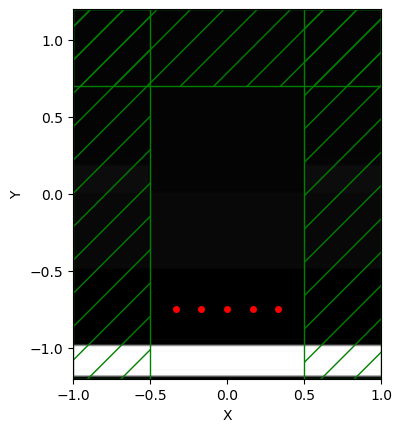

In [4]:
sim.plot2D()

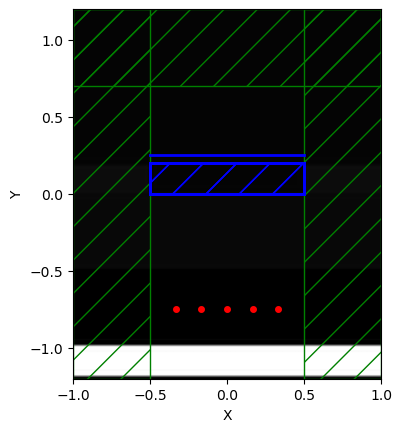

In [5]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)
opt.plot2D(True)

In [6]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [7]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [8]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    print("FoM: {}".format(np.real(f0)))
    print("Gradient: {}".format(np.real(dJ_du)))

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [9]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.7538933439841145
Gradient: [-2.55678021e-04 -6.08891639e-04 -6.28292370e-04 -4.16279695e-04
 -5.94587691e-05  3.45671923e-04  4.67219468e-04  3.68222780e-04
  1.37133584e-04 -1.04169096e-04 -4.09600538e-04 -2.08783022e-04
 -4.96412476e-04 -5.04455111e-04 -3.05349454e-04  2.02517588e-05
  3.78597569e-04  4.40572898e-04  2.95474199e-04  3.13050295e-05
 -2.23056003e-04 -5.73853274e-04 -2.41430487e-04 -5.71342657e-04
 -5.69308427e-04 -3.14834789e-04  8.90484868e-05  5.19614923e-04
  5.48471763e-04  3.15498726e-04 -6.18069795e-05 -4.06770848e-04
 -9.06555698e-04 -2.73998292e-04 -6.45608460e-04 -6.31838651e-04
 -3.19335138e-04  1.64849460e-04  6.66465553e-04  6.53959083e-04
  3.22471377e-04 -1.77780328e-04 -6.17818905e-04 -1.27343798e-03
 -3.07970271e-04 -7.24434791e-04 -7.01700000e-04 -3.30628873e-04
  2.37271845e-04  8.14818648e-04  7.63215501e-04  3.32188859e-04
 -2.93324323e-04 -8.29325454e-04 -1.63514356e-03 -3.45041707e-04
 -8.13571238e-04 -7.89192021e-04

Calculating gradient...
FoM: 0.7544929578675013
Gradient: [-2.56027552e-04 -6.09749109e-04 -6.29243848e-04 -4.17007506e-04
 -5.97424048e-05  3.45911349e-04  4.67658297e-04  3.68523125e-04
  1.37098241e-04 -1.04560719e-04 -4.10574227e-04 -2.09045917e-04
 -4.97064500e-04 -5.05184510e-04 -3.05876330e-04  2.01229124e-05
  3.78933443e-04  4.41025538e-04  2.95729695e-04  3.11811401e-05
 -2.23560425e-04 -5.75009263e-04 -2.41724143e-04 -5.72070266e-04
 -5.70112992e-04 -3.15378540e-04  8.90005653e-05  5.20139264e-04
  5.49087154e-04  3.15810838e-04 -6.20252847e-05 -4.07506381e-04
 -9.08195416e-04 -2.74329094e-04 -6.46422798e-04 -6.32720896e-04
 -3.19889484e-04  1.64897677e-04  6.67204851e-04  6.54764294e-04
  3.22865248e-04 -1.78071546e-04 -6.18768699e-04 -1.27554690e-03
 -3.08346332e-04 -7.25353271e-04 -7.02674674e-04 -3.31204185e-04
  2.37413807e-04  8.15786176e-04  7.64237924e-04  3.32703234e-04
 -2.93642067e-04 -8.30441414e-04 -1.63765917e-03 -3.45471621e-04
 -8.14615111e-04 -7.90285075e-04

Calculating gradient...
FoM: 0.7603236053494392
Gradient: [-2.59423002e-04 -6.18069086e-04 -6.38453669e-04 -4.24030688e-04
 -6.24490223e-05  3.48276009e-04  4.71926013e-04  3.71409939e-04
  1.36693036e-04 -1.08443389e-04 -4.20147259e-04 -2.11604695e-04
 -5.03401479e-04 -5.12253253e-04 -3.10964197e-04  1.89067502e-05
  3.82228707e-04  4.45429814e-04  2.98188779e-04  2.99266858e-05
 -2.28528463e-04 -5.86345928e-04 -2.44586802e-04 -5.79152559e-04
 -5.77921819e-04 -3.20637768e-04  8.85676782e-05  5.25269447e-04
  5.55079362e-04  3.18825254e-04 -6.41952875e-05 -4.14722678e-04
 -9.24246685e-04 -2.77557346e-04 -6.54359182e-04 -6.41297666e-04
 -3.25264348e-04  1.65391173e-04  6.74426707e-04  6.62612700e-04
  3.26689403e-04 -1.80934712e-04 -6.28055565e-04 -1.29615594e-03
 -3.12017637e-04 -7.34311092e-04 -7.12164197e-04 -3.36799507e-04
  2.38806149e-04  8.25228044e-04  7.74214153e-04  3.37724385e-04
 -2.96733350e-04 -8.41316868e-04 -1.66220250e-03 -3.49666990e-04
 -8.24796657e-04 -8.00938935e-04

Calculating gradient...
FoM: 0.8257294886247936
Gradient: [-2.96797250e-04 -7.09272166e-04 -7.38567554e-04 -4.99608128e-04
 -9.04495235e-05  3.75685083e-04  5.18242309e-04  3.99563531e-04
  1.25529773e-04 -1.59973929e-04 -5.39659976e-04 -2.40016423e-04
 -5.73435023e-04 -5.89675521e-04 -3.66124498e-04  6.72571746e-06
  4.19955883e-04  4.93997183e-04  3.22825945e-04  1.08197150e-05
 -2.90729089e-04 -7.24349194e-04 -2.76682257e-04 -6.58210759e-04
 -6.64417393e-04 -3.78514043e-04  8.46605271e-05  5.83806107e-04
  6.22261988e-04  3.50641130e-04 -9.27638120e-05 -5.01767836e-04
 -1.11600683e-03 -3.14043137e-04 -7.43786176e-04 -7.37520755e-04
 -3.85676771e-04  1.71052718e-04  7.56843267e-04  7.52211215e-04
  3.69824098e-04 -2.14857898e-04 -7.36318317e-04 -1.53806772e-03
 -3.53670012e-04 -8.35873878e-04 -8.19877329e-04 -4.01239014e-04
  2.53448514e-04  9.33099649e-04  8.90004727e-04  3.97758335e-04
 -3.29236322e-04 -9.63824208e-04 -1.94550832e-03 -3.97188804e-04
 -9.40404086e-04 -9.22886967e-04

Calculating gradient...
FoM: 1.1702163113848665
Gradient: [-4.44588379e-04 -1.08631812e-03 -1.18987865e-03 -8.74316377e-04
 -2.65802553e-04  4.66519440e-04  7.14263458e-04  4.88845000e-04
 -1.93572047e-05 -5.54903777e-04 -1.43929635e-03 -3.36109817e-04
 -8.32740944e-04 -9.24822979e-04 -6.42948843e-04 -9.33146814e-05
  5.71366956e-04  7.26423816e-04  4.35077927e-04 -1.20397541e-04
 -6.80682569e-04 -1.64240691e-03 -3.75685917e-04 -9.35420215e-04
 -1.03881118e-03 -6.83760510e-04  4.48553229e-06  8.38486457e-04
  9.78977950e-04  5.51106005e-04 -2.09783434e-04 -9.62030640e-04
 -2.27269620e-03 -4.19888808e-04 -1.04811154e-03 -1.16072570e-03
 -7.26487488e-04  1.12358729e-04  1.13744323e-03  1.27415261e-03
  7.12998730e-04 -2.55889429e-04 -1.20646292e-03 -2.86181895e-03
 -4.68692939e-04 -1.17400799e-03 -1.30204769e-03 -7.89180387e-04
  2.09732638e-04  1.45247462e-03  1.61371207e-03  9.39503976e-04
 -2.26940093e-04 -1.37506164e-03 -3.34826765e-03 -5.20881802e-04
 -1.31392323e-03 -1.47315103e-03

Calculating gradient...
FoM: 1.3005032405354444
Gradient: [-6.85661018e-04 -1.59045018e-03 -1.59164571e-03 -1.17273657e-03
 -4.59909471e-04  4.36562486e-04  8.82820396e-04  7.90814427e-04
  3.78024209e-04 -9.16734466e-05 -7.17236470e-04 -4.22657145e-04
 -1.00510058e-03 -1.04346238e-03 -7.27082770e-04 -1.52747281e-04
  5.90002910e-04  8.38537930e-04  6.13332770e-04  1.24536497e-04
 -3.70139460e-04 -1.11829466e-03 -3.80364627e-04 -9.30061353e-04
 -1.00402719e-03 -6.61601869e-04 -8.64829041e-06  8.32767864e-04
  9.99416395e-04  5.97349596e-04 -9.72849380e-05 -7.59915827e-04
 -1.85303307e-03 -3.35354315e-04 -8.51696868e-04 -9.68555954e-04
 -6.06560211e-04  1.21079283e-04  1.04573377e-03  1.11978994e-03
  5.29773606e-04 -3.78542422e-04 -1.21364135e-03 -2.67923230e-03
 -2.97126214e-04 -7.93022225e-04 -9.63152444e-04 -5.86599404e-04
  2.18129289e-04  1.23610198e-03  1.24045856e-03  4.74957078e-04
 -6.46715038e-04 -1.65746937e-03 -3.49458389e-03 -2.73166908e-04
 -7.72283099e-04 -1.00863488e-03

Calculating gradient...
FoM: 1.3118119907604318
Gradient: [-2.01980826e-04 -5.47747569e-04 -7.03748408e-04 -5.51032408e-04
 -1.85560695e-04  2.61816301e-04  3.69918876e-04  1.36162672e-04
 -2.54694830e-04 -5.90680214e-04 -1.14065689e-03 -1.00206474e-04
 -3.12580778e-04 -4.65276672e-04 -3.52059203e-04 -4.93424191e-05
  3.19444486e-04  3.17029123e-04 -1.04583873e-05 -4.71456537e-04
 -8.60808321e-04 -1.62111509e-03 -1.06433547e-04 -3.45058482e-04
 -5.27752386e-04 -3.79030335e-04  1.35271746e-05  4.90341095e-04
  4.37124133e-04 -4.88606104e-05 -7.06955596e-04 -1.27658629e-03
 -2.44396367e-03 -1.48754564e-04 -4.55987653e-04 -6.55932384e-04
 -4.39767549e-04  9.57699820e-05  7.58707730e-04  6.94509902e-04
  5.88365092e-05 -8.18687671e-04 -1.60317465e-03 -3.19529829e-03
 -2.25588333e-04 -6.43218757e-04 -8.50445948e-04 -5.34041126e-04
  2.03438200e-04  1.15311776e-03  1.14364663e-03  3.86787446e-04
 -7.25912404e-04 -1.75649391e-03 -3.75022772e-03 -3.33357909e-04
 -9.02186253e-04 -1.11637818e-03

Calculating gradient...
FoM: 1.3159834899181693
Gradient: [-5.06128471e-04 -1.19912262e-03 -1.25083446e-03 -9.40154616e-04
 -3.85463105e-04  2.87063504e-04  5.90091983e-04  4.69389590e-04
  1.28204528e-04 -2.16375604e-04 -6.46860754e-04 -2.70744220e-04
 -6.70651050e-04 -7.44720238e-04 -5.19948093e-04 -9.05206808e-05
  4.29880463e-04  5.25665540e-04  2.53312266e-04 -1.86336014e-04
 -5.84077518e-04 -1.23523314e-03 -2.27286314e-04 -5.90316460e-04
 -6.95143475e-04 -4.48157024e-04  4.32447321e-05  6.21006182e-04
  6.01172653e-04  1.30191045e-04 -5.22923072e-04 -1.09099577e-03
 -2.14425675e-03 -2.07263737e-04 -5.62639960e-04 -6.95069438e-04
 -4.12181036e-04  1.66344567e-04  8.27927196e-04  7.04360070e-04
  2.63680503e-05 -8.61396037e-04 -1.62221531e-03 -3.11934230e-03
 -2.17126006e-04 -6.02880609e-04 -7.59908624e-04 -4.20995873e-04
  2.83653120e-04  1.09551342e-03  9.17612719e-04  5.06971488e-05
 -1.08410380e-03 -2.06114445e-03 -3.99993483e-03 -2.59813175e-04
 -7.19320923e-04 -9.01323661e-04

Calculating gradient...
FoM: 1.3182446724119161
Gradient: [-3.32934088e-04 -8.33156156e-04 -9.55844625e-04 -7.40466651e-04
 -2.89215069e-04  2.75144758e-04  4.99722763e-04  3.47147429e-04
  3.84404021e-06 -3.24510931e-04 -7.68968087e-04 -1.64269744e-04
 -4.48846827e-04 -5.75811581e-04 -4.21070839e-04 -6.55663195e-05
  3.75994951e-04  4.29883567e-04  1.44329033e-04 -2.89853276e-04
 -6.74448631e-04 -1.34943501e-03 -1.41687726e-04 -4.15832438e-04
 -5.73503364e-04 -3.92841112e-04  3.32796774e-05  5.47092055e-04
  5.08986496e-04  3.88549207e-05 -6.02884218e-04 -1.16115810e-03
 -2.24761826e-03 -1.50919108e-04 -4.52513776e-04 -6.31698417e-04
 -4.01293095e-04  1.34155506e-04  7.69879770e-04  6.63211308e-04
  6.10182082e-06 -8.67129559e-04 -1.62840760e-03 -3.16231793e-03
 -1.94164847e-04 -5.64713301e-04 -7.56955596e-04 -4.47914409e-04
  2.48025044e-04  1.09195143e-03  9.74032647e-04  1.52265992e-04
 -9.67661445e-04 -1.96256221e-03 -3.93598920e-03 -2.71101936e-04
 -7.54189984e-04 -9.57078998e-04

Calculating gradient...
FoM: 1.319266446214925
Gradient: [-4.18719983e-04 -1.01519107e-03 -1.10418368e-03 -8.40871770e-04
 -3.34564702e-04  2.92911910e-04  5.64687318e-04  4.34577957e-04
  9.56098843e-05 -2.38783925e-04 -6.57031287e-04 -2.10985179e-04
 -5.46085085e-04 -6.49215572e-04 -4.61571011e-04 -6.93931227e-05
  4.14879645e-04  4.91217830e-04  2.13687591e-04 -2.22453577e-04
 -6.11422315e-04 -1.25987131e-03 -1.73340507e-04 -4.79538579e-04
 -6.15187273e-04 -4.06455559e-04  4.83050098e-05  5.91027806e-04
  5.58625559e-04  8.62276047e-05 -5.60273357e-04 -1.11929214e-03
 -2.17540766e-03 -1.64240797e-04 -4.76271654e-04 -6.38397374e-04
 -3.90232817e-04  1.57731519e-04  7.94567644e-04  6.70637897e-04
 -9.14552391e-07 -8.78946114e-04 -1.63333295e-03 -3.13774752e-03
 -1.88127351e-04 -5.46903243e-04 -7.29313141e-04 -4.16600977e-04
  2.70038007e-04  1.07845636e-03  9.17192722e-04  6.79488143e-05
 -1.05487171e-03 -2.03251701e-03 -3.98134049e-03 -2.46247976e-04
 -6.96130695e-04 -8.96681271e-04 

Calculating gradient...
FoM: 1.3198982097550613
Gradient: [-4.10775680e-04 -1.00083978e-03 -1.09896373e-03 -8.43546340e-04
 -3.42028301e-04  2.84890720e-04  5.64803414e-04  4.46456161e-04
  1.19159060e-04 -2.04916062e-04 -5.90701532e-04 -2.03231659e-04
 -5.30496066e-04 -6.38691495e-04 -4.56275365e-04 -6.80650020e-05
  4.13769443e-04  4.91308795e-04  2.19366092e-04 -2.09004982e-04
 -5.88731293e-04 -1.20948366e-03 -1.64627958e-04 -4.61073377e-04
 -6.00200826e-04 -3.96312132e-04  5.33794831e-05  5.88660158e-04
  5.51096198e-04  8.04160223e-05 -5.58684309e-04 -1.10665567e-03
 -2.13442150e-03 -1.55733217e-04 -4.57191178e-04 -6.20284157e-04
 -3.75924422e-04  1.65236122e-04  7.87408439e-04  6.50190142e-04
 -2.52469545e-05 -8.97439341e-04 -1.63956972e-03 -3.11926344e-03
 -1.80962301e-04 -5.29349004e-04 -7.09041096e-04 -3.97827428e-04
  2.80965974e-04  1.06803226e-03  8.84071355e-04  2.32664033e-05
 -1.09711289e-03 -2.06252375e-03 -3.99363623e-03 -2.41610890e-04
 -6.82322379e-04 -8.75048431e-04

Calculating gradient...
FoM: 1.3201447941246456
Gradient: [-4.09693821e-04 -9.99236839e-04 -1.09925023e-03 -8.44434498e-04
 -3.41374739e-04  2.90690253e-04  5.75024470e-04  4.58170662e-04
  1.26653089e-04 -2.05740039e-04 -6.08443578e-04 -1.96225964e-04
 -5.16723390e-04 -6.30017317e-04 -4.51716224e-04 -6.51158606e-05
  4.19283313e-04  5.00232387e-04  2.30388359e-04 -2.01339341e-04
 -5.89374739e-04 -1.22974472e-03 -1.51794455e-04 -4.35694420e-04
 -5.83918549e-04 -3.87899633e-04  5.77410404e-05  5.95051295e-04
  5.62224043e-04  9.72064517e-05 -5.44377341e-04 -1.10363263e-03
 -2.15918803e-03 -1.36956508e-04 -4.20113539e-04 -5.96675714e-04
 -3.64020406e-04  1.71124632e-04  7.96322030e-04  6.66766884e-04
  1.83056724e-06 -8.71873149e-04 -1.62865323e-03 -3.14385905e-03
 -1.56062115e-04 -4.80229538e-04 -6.77838464e-04 -3.81864448e-04
  2.89949794e-04  1.08360628e-03  9.12283703e-04  6.50955437e-05
 -1.05643910e-03 -2.03949392e-03 -4.01176217e-03 -2.10047231e-04
 -6.19926182e-04 -8.34901463e-04

Calculating gradient...
FoM: 1.3201447941246456
Gradient: [-4.09693821e-04 -9.99236839e-04 -1.09925023e-03 -8.44434498e-04
 -3.41374739e-04  2.90690253e-04  5.75024470e-04  4.58170662e-04
  1.26653089e-04 -2.05740039e-04 -6.08443578e-04 -1.96225964e-04
 -5.16723390e-04 -6.30017317e-04 -4.51716224e-04 -6.51158606e-05
  4.19283313e-04  5.00232387e-04  2.30388359e-04 -2.01339341e-04
 -5.89374739e-04 -1.22974472e-03 -1.51794455e-04 -4.35694420e-04
 -5.83918549e-04 -3.87899633e-04  5.77410404e-05  5.95051295e-04
  5.62224043e-04  9.72064517e-05 -5.44377341e-04 -1.10363263e-03
 -2.15918803e-03 -1.36956508e-04 -4.20113539e-04 -5.96675714e-04
 -3.64020406e-04  1.71124632e-04  7.96322030e-04  6.66766884e-04
  1.83056724e-06 -8.71873149e-04 -1.62865323e-03 -3.14385905e-03
 -1.56062115e-04 -4.80229538e-04 -6.77838464e-04 -3.81864448e-04
  2.89949794e-04  1.08360628e-03  9.12283703e-04  6.50955437e-05
 -1.05643910e-03 -2.03949392e-03 -4.01176217e-03 -2.10047231e-04
 -6.19926182e-04 -8.34901463e-04

Calculating gradient...
FoM: 1.3201448091566284
Gradient: [-4.09692729e-04 -9.99234439e-04 -1.09924807e-03 -8.44432878e-04
 -3.41373979e-04  2.90689694e-04  5.75022800e-04  4.58168513e-04
  1.26651115e-04 -2.05741358e-04 -6.08443991e-04 -1.96225568e-04
 -5.16722477e-04 -6.30016406e-04 -4.51715527e-04 -6.51156550e-05
  4.19282562e-04  5.00230847e-04  2.30386483e-04 -2.01341022e-04
 -5.89375857e-04 -1.22974506e-03 -1.51794461e-04 -4.35694333e-04
 -5.83918239e-04 -3.87899281e-04  5.77411146e-05  5.95050521e-04
  5.62222477e-04  9.72045077e-05 -5.44379116e-04 -1.10363383e-03
 -2.15918840e-03 -1.36956985e-04 -4.20114399e-04 -5.96676030e-04
 -3.64020296e-04  1.71124822e-04  7.96321658e-04  6.66765701e-04
  1.82888746e-06 -8.71874801e-04 -1.62865440e-03 -3.14385944e-03
 -1.56063099e-04 -4.80231400e-04 -6.77839380e-04 -3.81864446e-04
  2.89950362e-04  1.08360670e-03  9.12283252e-04  6.50943815e-05
 -1.05644048e-03 -2.03949501e-03 -4.01176260e-03 -2.10048751e-04
 -6.19929096e-04 -8.34902984e-04

Calculating gradient...
FoM: 1.3201448091566284
Gradient: [-4.09692729e-04 -9.99234439e-04 -1.09924807e-03 -8.44432878e-04
 -3.41373979e-04  2.90689694e-04  5.75022800e-04  4.58168513e-04
  1.26651115e-04 -2.05741358e-04 -6.08443991e-04 -1.96225568e-04
 -5.16722477e-04 -6.30016406e-04 -4.51715527e-04 -6.51156550e-05
  4.19282562e-04  5.00230847e-04  2.30386483e-04 -2.01341022e-04
 -5.89375857e-04 -1.22974506e-03 -1.51794461e-04 -4.35694333e-04
 -5.83918239e-04 -3.87899281e-04  5.77411146e-05  5.95050521e-04
  5.62222477e-04  9.72045077e-05 -5.44379116e-04 -1.10363383e-03
 -2.15918840e-03 -1.36956985e-04 -4.20114399e-04 -5.96676030e-04
 -3.64020296e-04  1.71124822e-04  7.96321658e-04  6.66765701e-04
  1.82888746e-06 -8.71874801e-04 -1.62865440e-03 -3.14385944e-03
 -1.56063099e-04 -4.80231400e-04 -6.77839380e-04 -3.81864446e-04
  2.89950362e-04  1.08360670e-03  9.12283252e-04  6.50943815e-05
 -1.05644048e-03 -2.03949501e-03 -4.01176260e-03 -2.10048751e-04
 -6.19929096e-04 -8.34902984e-04

Calculating gradient...
FoM: 1.3201448241862643
Gradient: [-4.09691637e-04 -9.99232040e-04 -1.09924591e-03 -8.44431257e-04
 -3.41373220e-04  2.90689135e-04  5.75021131e-04  4.58166364e-04
  1.26649142e-04 -2.05742676e-04 -6.08444404e-04 -1.96225171e-04
 -5.16721564e-04 -6.30015496e-04 -4.51714830e-04 -6.51154495e-05
  4.19281811e-04  5.00229308e-04  2.30384607e-04 -2.01342703e-04
 -5.89376974e-04 -1.22974540e-03 -1.51794467e-04 -4.35694246e-04
 -5.83917928e-04 -3.87898928e-04  5.77411888e-05  5.95049748e-04
  5.62220911e-04  9.72025638e-05 -5.44380890e-04 -1.10363504e-03
 -2.15918876e-03 -1.36957462e-04 -4.20115259e-04 -5.96676345e-04
 -3.64020187e-04  1.71125012e-04  7.96321286e-04  6.66764518e-04
  1.82720786e-06 -8.71876453e-04 -1.62865558e-03 -3.14385982e-03
 -1.56064083e-04 -4.80233261e-04 -6.77840296e-04 -3.81864444e-04
  2.89950930e-04  1.08360713e-03  9.12282801e-04  6.50932195e-05
 -1.05644185e-03 -2.03949609e-03 -4.01176303e-03 -2.10050270e-04
 -6.19932009e-04 -8.34904504e-04

Calculating gradient...
FoM: 1.3201448241862643
Gradient: [-4.09691637e-04 -9.99232040e-04 -1.09924591e-03 -8.44431257e-04
 -3.41373220e-04  2.90689135e-04  5.75021131e-04  4.58166364e-04
  1.26649142e-04 -2.05742676e-04 -6.08444404e-04 -1.96225171e-04
 -5.16721564e-04 -6.30015496e-04 -4.51714830e-04 -6.51154495e-05
  4.19281811e-04  5.00229308e-04  2.30384607e-04 -2.01342703e-04
 -5.89376974e-04 -1.22974540e-03 -1.51794467e-04 -4.35694246e-04
 -5.83917928e-04 -3.87898928e-04  5.77411888e-05  5.95049748e-04
  5.62220911e-04  9.72025638e-05 -5.44380890e-04 -1.10363504e-03
 -2.15918876e-03 -1.36957462e-04 -4.20115259e-04 -5.96676345e-04
 -3.64020187e-04  1.71125012e-04  7.96321286e-04  6.66764518e-04
  1.82720786e-06 -8.71876453e-04 -1.62865558e-03 -3.14385982e-03
 -1.56064083e-04 -4.80233261e-04 -6.77840296e-04 -3.81864444e-04
  2.89950930e-04  1.08360713e-03  9.12282801e-04  6.50932195e-05
 -1.05644185e-03 -2.03949609e-03 -4.01176303e-03 -2.10050270e-04
 -6.19932009e-04 -8.34904504e-04

Calculating gradient...
FoM: 1.3201448392135529
Gradient: [-4.09690546e-04 -9.99229641e-04 -1.09924374e-03 -8.44429638e-04
 -3.41372460e-04  2.90688577e-04  5.75019462e-04  4.58164215e-04
  1.26647169e-04 -2.05743994e-04 -6.08444818e-04 -1.96224775e-04
 -5.16720652e-04 -6.30014585e-04 -4.51714134e-04 -6.51152440e-05
  4.19281060e-04  5.00227768e-04  2.30382731e-04 -2.01344383e-04
 -5.89378092e-04 -1.22974574e-03 -1.51794474e-04 -4.35694159e-04
 -5.83917617e-04 -3.87898575e-04  5.77412631e-05  5.95048975e-04
  5.62219346e-04  9.72006202e-05 -5.44382664e-04 -1.10363624e-03
 -2.15918913e-03 -1.36957938e-04 -4.20116119e-04 -5.96676661e-04
 -3.64020077e-04  1.71125202e-04  7.96320913e-04  6.66763335e-04
  1.82552842e-06 -8.71878104e-04 -1.62865675e-03 -3.14386020e-03
 -1.56065066e-04 -4.80235123e-04 -6.77841212e-04 -3.81864441e-04
  2.89951498e-04  1.08360756e-03  9.12282350e-04  6.50920575e-05
 -1.05644323e-03 -2.03949717e-03 -4.01176346e-03 -2.10051789e-04
 -6.19934921e-04 -8.34906024e-04

Calculating gradient...
FoM: 1.3201448392135529
Gradient: [-4.09690546e-04 -9.99229641e-04 -1.09924374e-03 -8.44429638e-04
 -3.41372460e-04  2.90688577e-04  5.75019462e-04  4.58164215e-04
  1.26647169e-04 -2.05743994e-04 -6.08444818e-04 -1.96224775e-04
 -5.16720652e-04 -6.30014585e-04 -4.51714134e-04 -6.51152440e-05
  4.19281060e-04  5.00227768e-04  2.30382731e-04 -2.01344383e-04
 -5.89378092e-04 -1.22974574e-03 -1.51794474e-04 -4.35694159e-04
 -5.83917617e-04 -3.87898575e-04  5.77412631e-05  5.95048975e-04
  5.62219346e-04  9.72006202e-05 -5.44382664e-04 -1.10363624e-03
 -2.15918913e-03 -1.36957938e-04 -4.20116119e-04 -5.96676661e-04
 -3.64020077e-04  1.71125202e-04  7.96320913e-04  6.66763335e-04
  1.82552842e-06 -8.71878104e-04 -1.62865675e-03 -3.14386020e-03
 -1.56065066e-04 -4.80235123e-04 -6.77841212e-04 -3.81864441e-04
  2.89951498e-04  1.08360756e-03  9.12282350e-04  6.50920575e-05
 -1.05644323e-03 -2.03949717e-03 -4.01176346e-03 -2.10051789e-04
 -6.19934921e-04 -8.34906024e-04

Calculating gradient...
FoM: 1.3201448542384953
Gradient: [-4.09689455e-04 -9.99227242e-04 -1.09924158e-03 -8.44428018e-04
 -3.41371701e-04  2.90688019e-04  5.75017793e-04  4.58162067e-04
  1.26645196e-04 -2.05745311e-04 -6.08445231e-04 -1.96224378e-04
 -5.16719739e-04 -6.30013675e-04 -4.51713437e-04 -6.51150385e-05
  4.19280310e-04  5.00226229e-04  2.30380855e-04 -2.01346064e-04
 -5.89379209e-04 -1.22974608e-03 -1.51794480e-04 -4.35694073e-04
 -5.83917307e-04 -3.87898223e-04  5.77413373e-05  5.95048201e-04
  5.62217781e-04  9.71986768e-05 -5.44384438e-04 -1.10363744e-03
 -2.15918950e-03 -1.36958415e-04 -4.20116978e-04 -5.96676976e-04
 -3.64019967e-04  1.71125392e-04  7.96320541e-04  6.66762152e-04
  1.82384916e-06 -8.71879756e-04 -1.62865792e-03 -3.14386058e-03
 -1.56066050e-04 -4.80236984e-04 -6.77842127e-04 -3.81864439e-04
  2.89952066e-04  1.08360799e-03  9.12281899e-04  6.50908956e-05
 -1.05644460e-03 -2.03949826e-03 -4.01176388e-03 -2.10053308e-04
 -6.19937833e-04 -8.34907543e-04

Calculating gradient...
FoM: 1.3201448542384953
Gradient: [-4.09689455e-04 -9.99227242e-04 -1.09924158e-03 -8.44428018e-04
 -3.41371701e-04  2.90688019e-04  5.75017793e-04  4.58162067e-04
  1.26645196e-04 -2.05745311e-04 -6.08445231e-04 -1.96224378e-04
 -5.16719739e-04 -6.30013675e-04 -4.51713437e-04 -6.51150385e-05
  4.19280310e-04  5.00226229e-04  2.30380855e-04 -2.01346064e-04
 -5.89379209e-04 -1.22974608e-03 -1.51794480e-04 -4.35694073e-04
 -5.83917307e-04 -3.87898223e-04  5.77413373e-05  5.95048201e-04
  5.62217781e-04  9.71986768e-05 -5.44384438e-04 -1.10363744e-03
 -2.15918950e-03 -1.36958415e-04 -4.20116978e-04 -5.96676976e-04
 -3.64019967e-04  1.71125392e-04  7.96320541e-04  6.66762152e-04
  1.82384916e-06 -8.71879756e-04 -1.62865792e-03 -3.14386058e-03
 -1.56066050e-04 -4.80236984e-04 -6.77842127e-04 -3.81864439e-04
  2.89952066e-04  1.08360799e-03  9.12281899e-04  6.50908956e-05
 -1.05644460e-03 -2.03949826e-03 -4.01176388e-03 -2.10053308e-04
 -6.19937833e-04 -8.34907543e-04

Calculating gradient...
FoM: 1.32014486926109
Gradient: [-4.09688364e-04 -9.99224843e-04 -1.09923942e-03 -8.44426398e-04
 -3.41370941e-04  2.90687460e-04  5.75016125e-04  4.58159918e-04
  1.26643224e-04 -2.05746629e-04 -6.08445644e-04 -1.96223982e-04
 -5.16718827e-04 -6.30012765e-04 -4.51712740e-04 -6.51148330e-05
  4.19279559e-04  5.00224690e-04  2.30378979e-04 -2.01347744e-04
 -5.89380327e-04 -1.22974642e-03 -1.51794486e-04 -4.35693986e-04
 -5.83916996e-04 -3.87897870e-04  5.77414116e-05  5.95047428e-04
  5.62216216e-04  9.71967336e-05 -5.44386212e-04 -1.10363864e-03
 -2.15918986e-03 -1.36958892e-04 -4.20117838e-04 -5.96677292e-04
 -3.64019857e-04  1.71125582e-04  7.96320169e-04  6.66760970e-04
  1.82217007e-06 -8.71881407e-04 -1.62865910e-03 -3.14386096e-03
 -1.56067033e-04 -4.80238845e-04 -6.77843043e-04 -3.81864437e-04
  2.89952634e-04  1.08360841e-03  9.12281449e-04  6.50897338e-05
 -1.05644598e-03 -2.03949934e-03 -4.01176431e-03 -2.10054827e-04
 -6.19940745e-04 -8.34909063e-04 -

Calculating gradient...
FoM: 1.32014486926109
Gradient: [-4.09688364e-04 -9.99224843e-04 -1.09923942e-03 -8.44426398e-04
 -3.41370941e-04  2.90687460e-04  5.75016125e-04  4.58159918e-04
  1.26643224e-04 -2.05746629e-04 -6.08445644e-04 -1.96223982e-04
 -5.16718827e-04 -6.30012765e-04 -4.51712740e-04 -6.51148330e-05
  4.19279559e-04  5.00224690e-04  2.30378979e-04 -2.01347744e-04
 -5.89380327e-04 -1.22974642e-03 -1.51794486e-04 -4.35693986e-04
 -5.83916996e-04 -3.87897870e-04  5.77414116e-05  5.95047428e-04
  5.62216216e-04  9.71967336e-05 -5.44386212e-04 -1.10363864e-03
 -2.15918986e-03 -1.36958892e-04 -4.20117838e-04 -5.96677292e-04
 -3.64019857e-04  1.71125582e-04  7.96320169e-04  6.66760970e-04
  1.82217007e-06 -8.71881407e-04 -1.62865910e-03 -3.14386096e-03
 -1.56067033e-04 -4.80238845e-04 -6.77843043e-04 -3.81864437e-04
  2.89952634e-04  1.08360841e-03  9.12281449e-04  6.50897338e-05
 -1.05644598e-03 -2.03949934e-03 -4.01176431e-03 -2.10054827e-04
 -6.19940745e-04 -8.34909063e-04 -

Calculating gradient...
FoM: 1.3201448842813401
Gradient: [-4.09687273e-04 -9.99222445e-04 -1.09923726e-03 -8.44424779e-04
 -3.41370182e-04  2.90686902e-04  5.75014456e-04  4.58157770e-04
  1.26641251e-04 -2.05747946e-04 -6.08446056e-04 -1.96223586e-04
 -5.16717914e-04 -6.30011855e-04 -4.51712044e-04 -6.51146276e-05
  4.19278809e-04  5.00223151e-04  2.30377104e-04 -2.01349424e-04
 -5.89381444e-04 -1.22974676e-03 -1.51794493e-04 -4.35693899e-04
 -5.83916686e-04 -3.87897518e-04  5.77414858e-05  5.95046655e-04
  5.62214651e-04  9.71947907e-05 -5.44387986e-04 -1.10363984e-03
 -2.15919023e-03 -1.36959368e-04 -4.20118697e-04 -5.96677607e-04
 -3.64019748e-04  1.71125772e-04  7.96319797e-04  6.66759787e-04
  1.82049115e-06 -8.71883059e-04 -1.62866027e-03 -3.14386134e-03
 -1.56068016e-04 -4.80240706e-04 -6.77843958e-04 -3.81864434e-04
  2.89953201e-04  1.08360884e-03  9.12280998e-04  6.50885721e-05
 -1.05644735e-03 -2.03950042e-03 -4.01176474e-03 -2.10056346e-04
 -6.19943657e-04 -8.34910582e-04

Calculating gradient...
FoM: 1.3201448842813401
Gradient: [-4.09687273e-04 -9.99222445e-04 -1.09923726e-03 -8.44424779e-04
 -3.41370182e-04  2.90686902e-04  5.75014456e-04  4.58157770e-04
  1.26641251e-04 -2.05747946e-04 -6.08446056e-04 -1.96223586e-04
 -5.16717914e-04 -6.30011855e-04 -4.51712044e-04 -6.51146276e-05
  4.19278809e-04  5.00223151e-04  2.30377104e-04 -2.01349424e-04
 -5.89381444e-04 -1.22974676e-03 -1.51794493e-04 -4.35693899e-04
 -5.83916686e-04 -3.87897518e-04  5.77414858e-05  5.95046655e-04
  5.62214651e-04  9.71947907e-05 -5.44387986e-04 -1.10363984e-03
 -2.15919023e-03 -1.36959368e-04 -4.20118697e-04 -5.96677607e-04
 -3.64019748e-04  1.71125772e-04  7.96319797e-04  6.66759787e-04
  1.82049115e-06 -8.71883059e-04 -1.62866027e-03 -3.14386134e-03
 -1.56068016e-04 -4.80240706e-04 -6.77843958e-04 -3.81864434e-04
  2.89953201e-04  1.08360884e-03  9.12280998e-04  6.50885721e-05
 -1.05644735e-03 -2.03950042e-03 -4.01176474e-03 -2.10056346e-04
 -6.19943657e-04 -8.34910582e-04

Calculating gradient...
FoM: 1.3201448992992437
Gradient: [-4.09686182e-04 -9.99220047e-04 -1.09923510e-03 -8.44423160e-04
 -3.41369423e-04  2.90686343e-04  5.75012788e-04  4.58155622e-04
  1.26639279e-04 -2.05749264e-04 -6.08446469e-04 -1.96223190e-04
 -5.16717002e-04 -6.30010945e-04 -4.51711347e-04 -6.51144222e-05
  4.19278058e-04  5.00221612e-04  2.30375229e-04 -2.01351103e-04
 -5.89382561e-04 -1.22974710e-03 -1.51794499e-04 -4.35693812e-04
 -5.83916375e-04 -3.87897165e-04  5.77415601e-05  5.95045882e-04
  5.62213086e-04  9.71928479e-05 -5.44389759e-04 -1.10364104e-03
 -2.15919059e-03 -1.36959844e-04 -4.20119557e-04 -5.96677922e-04
 -3.64019638e-04  1.71125962e-04  7.96319424e-04  6.66758605e-04
  1.81881241e-06 -8.71884710e-04 -1.62866145e-03 -3.14386172e-03
 -1.56069000e-04 -4.80242566e-04 -6.77844874e-04 -3.81864432e-04
  2.89953769e-04  1.08360927e-03  9.12280547e-04  6.50874105e-05
 -1.05644873e-03 -2.03950151e-03 -4.01176517e-03 -2.10057864e-04
 -6.19946568e-04 -8.34912101e-04

Calculating gradient...
FoM: 1.3201448992992437
Gradient: [-4.09686182e-04 -9.99220047e-04 -1.09923510e-03 -8.44423160e-04
 -3.41369423e-04  2.90686343e-04  5.75012788e-04  4.58155622e-04
  1.26639279e-04 -2.05749264e-04 -6.08446469e-04 -1.96223190e-04
 -5.16717002e-04 -6.30010945e-04 -4.51711347e-04 -6.51144222e-05
  4.19278058e-04  5.00221612e-04  2.30375229e-04 -2.01351103e-04
 -5.89382561e-04 -1.22974710e-03 -1.51794499e-04 -4.35693812e-04
 -5.83916375e-04 -3.87897165e-04  5.77415601e-05  5.95045882e-04
  5.62213086e-04  9.71928479e-05 -5.44389759e-04 -1.10364104e-03
 -2.15919059e-03 -1.36959844e-04 -4.20119557e-04 -5.96677922e-04
 -3.64019638e-04  1.71125962e-04  7.96319424e-04  6.66758605e-04
  1.81881241e-06 -8.71884710e-04 -1.62866145e-03 -3.14386172e-03
 -1.56069000e-04 -4.80242566e-04 -6.77844874e-04 -3.81864432e-04
  2.89953769e-04  1.08360927e-03  9.12280547e-04  6.50874105e-05
 -1.05644873e-03 -2.03950151e-03 -4.01176517e-03 -2.10057864e-04
 -6.19946568e-04 -8.34912101e-04

In [10]:
np.savetxt("lastdesign.txt", design_variables.weights)

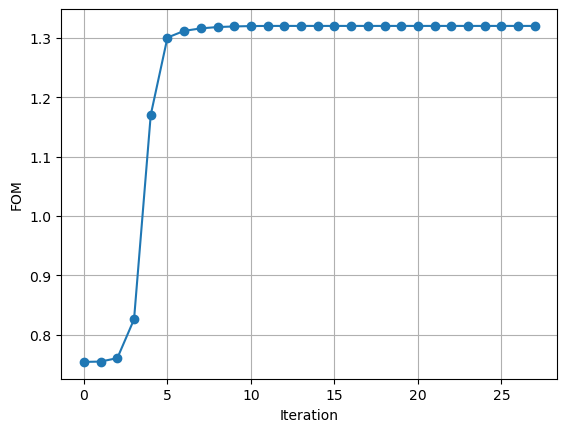

In [11]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

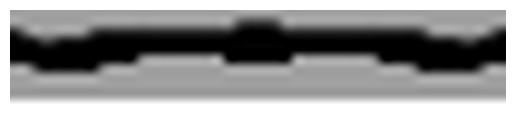

In [12]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

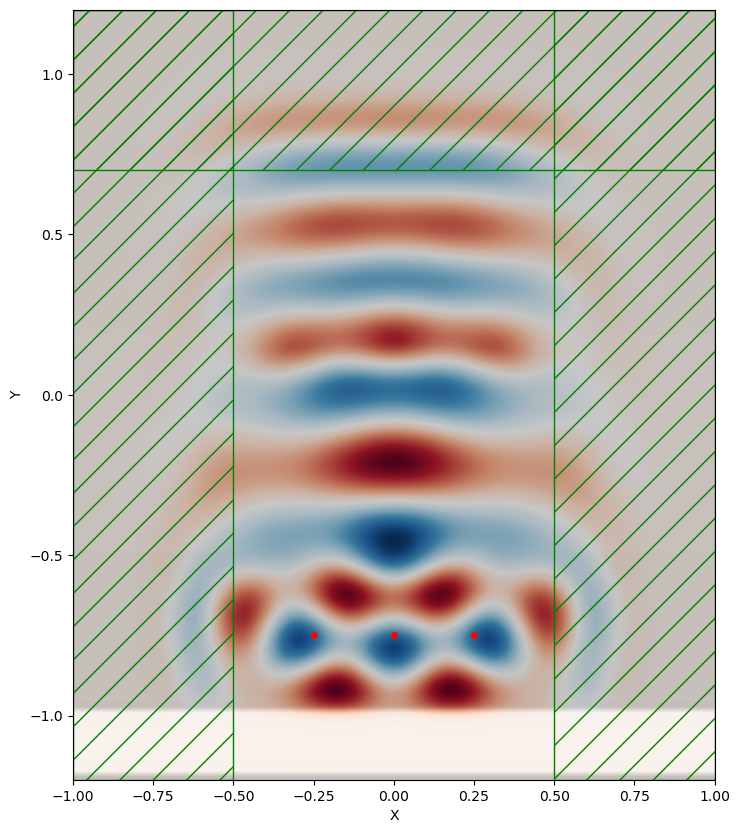

In [ ]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 5

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

In [14]:
opt.sim.reset_meep()

In [15]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)

In [16]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = (design_region_width)*(math.trunc(src_num)/(src_num+1))
srcbox_top = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))



<Axes: xlabel='X', ylabel='Y'>

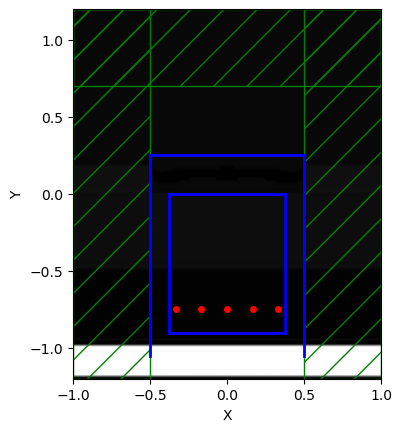

In [17]:
opt.sim.plot2D()

In [18]:
opt.sim.run(until=100.0)

In [19]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)



In [20]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

In [21]:
print(flux_waveguide)

[4.89840282e-06 2.82586537e-05 1.44061852e-04 4.70484444e-04
 1.44947457e-03 5.34975389e-03 1.79186964e-02 3.82333382e-02
 7.58037449e-02 1.51963114e-01 2.72178881e-01 4.02086660e-01
 4.40949490e-01 3.06450708e-01 1.73472975e-01 1.11622032e-01
 7.44794420e-02 4.50742393e-02 2.78579414e-02 1.43536925e-02
 5.82350555e-03 1.98660235e-03 6.07191998e-04 1.57421798e-04
 3.22018250e-05]


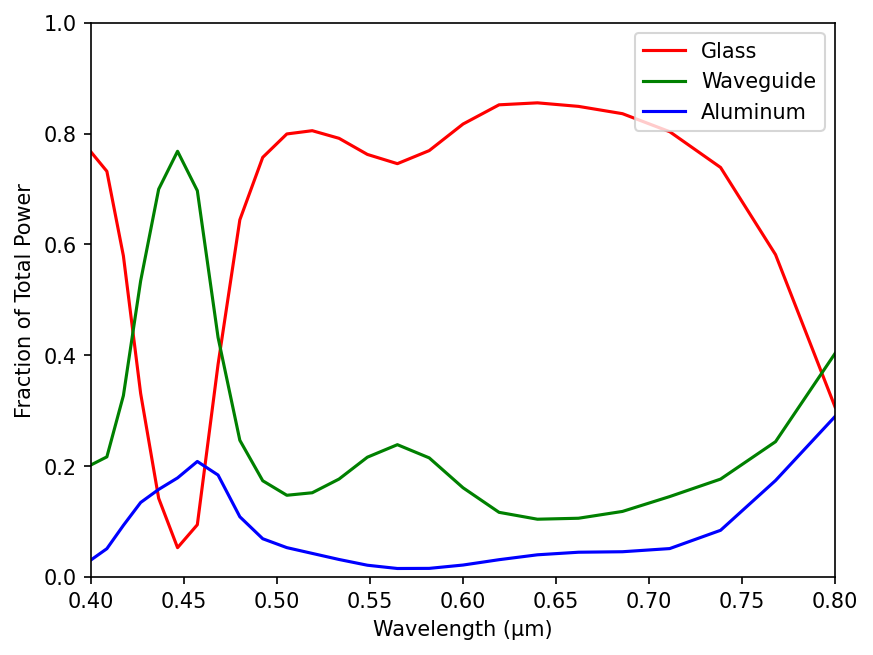

In [22]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [23]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

In [24]:
# opt.simo.reset_meep()

In [25]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)

In [26]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = (design_region_width)*(math.trunc(src_num)/(src_num+1))
srcbox_top = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))


<Axes: xlabel='X', ylabel='Y'>

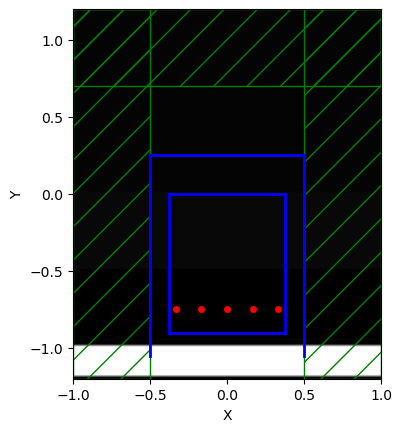

In [27]:
opt.simo.plot2D()

In [28]:
opt.simo.run(until=300.0)

In [29]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)


In [30]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

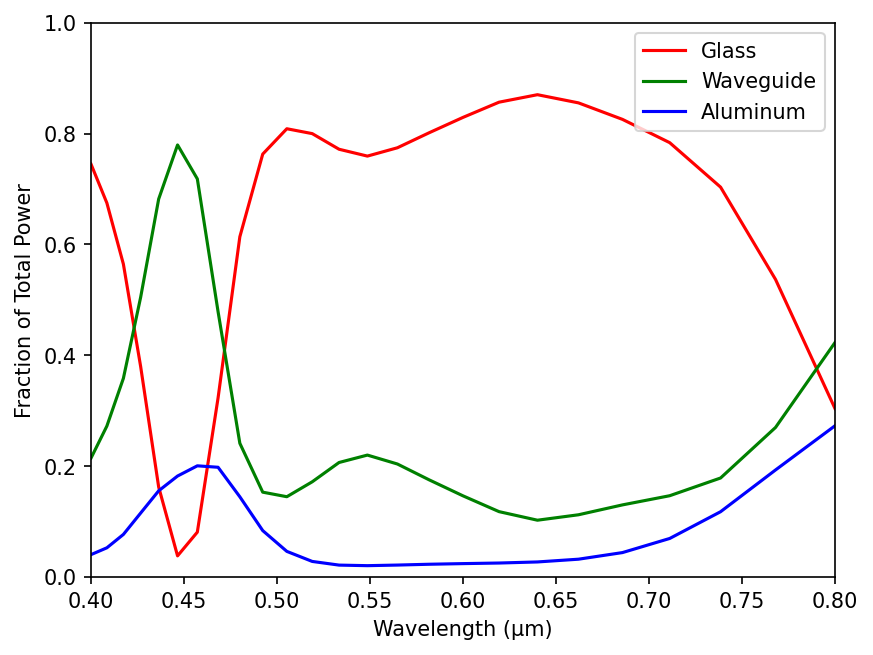

In [31]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

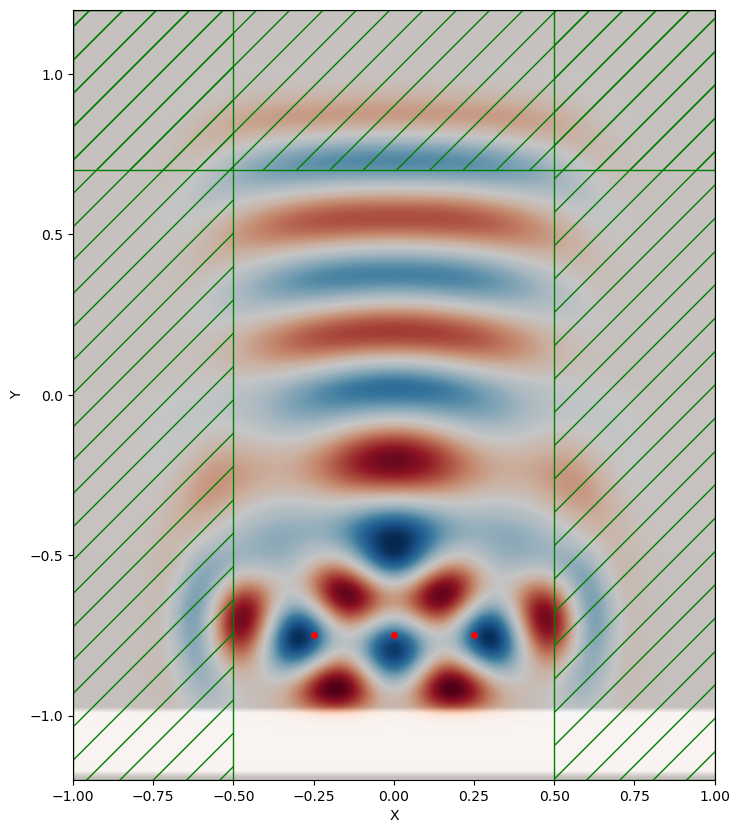

In [32]:
opt.simo.reset_meep()
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = []
src_num = 3

for i in range(src_num):  # x 방향 루프
        source.append(
            mp.Source(
                src,
                component=mp.Ez,
                center=mp.Vector3(
                    x = -design_region_width/2 + (design_region_width)*((i+1)/(src_num+1)),  
                    y = 0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG,
                    z = 0
                )
            )
        )

opt.simo.change_sources(source)

plt.figure(figsize=(16, 10))

opt.simo.run(until=300)
opt.simo.plot2D(fields=mp.Ez)
opt.simo.reset_meep()